# ***##step by step denoise##***

## 1.创建各个部分的模型

In [1]:

# control_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_crack_only_generate/checkpoint-2000/controlnet'
control_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_inpainting_h-256_w-256_2024-07-05_09:14:29_seeds-2024/checkpoint-2000/controlnet'
config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'

In [2]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, ControlNetModel
import os

vae = AutoencoderKL.from_pretrained(config_dir, subfolder='vae', use_safetensors=None)
tokenizer = CLIPTokenizer.from_pretrained(config_dir, subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained(config_dir, subfolder='text_encoder', use_safetensors=None)
unet = UNet2DConditionModel.from_pretrained(config_dir, subfolder='unet', use_safetensors=None)

controlnet = ControlNetModel.from_pretrained(control_dir)
controlnet.config

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


FrozenDict([('in_channels', 4),
            ('conditioning_channels', 3),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 768),
            ('transformer_layers_per_block', 1),
            ('encoder_hid_dim', None),
            ('encoder_hid_dim_type', None),
            ('attention_head_dim', 8),
            ('num_attention_heads', None),
            ('use_linear_projection',

In [3]:
from diffusers import UniPCMultistepScheduler

scheduler_multistep = UniPCMultistepScheduler.from_pretrained(config_dir, subfolder="scheduler")
# scheduler_multistep.config

In [4]:
from diffusers import DDPMScheduler
scheduler_ddpm = DDPMScheduler.from_pretrained(config_dir, subfolder='scheduler')

In [5]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
controlnet.to(torch_device)
print('')
# unet.config

## 2.Create embeddings

### 2.1 Create text embeddings

In [6]:
prompt = ["crack"]
device = 'cuda'
seed = 1
height = 256  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device=device).manual_seed(seed)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [7]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

prompt_embeds = text_embeddings
encoder_hidden_states_control = text_embeddings
text_embeddings.shape

torch.Size([1, 77, 768])

In [8]:
'''
You’ll also need to generate the unconditional text embeddings which are the embeddings for the padding token.
These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:
'''
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
uncond_embeddings.shape, text_embeddings.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [9]:
# Let’s concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# text_embeddings
text_embeddings.shape

torch.Size([2, 77, 768])

In [10]:
text_embeddings.shape

torch.Size([2, 77, 768])

### 2.2 Create image embeddings

torch.Size([1, 3, 256, 512])
torch.Size([1, 3, 256, 512])
RGB
RGB
L


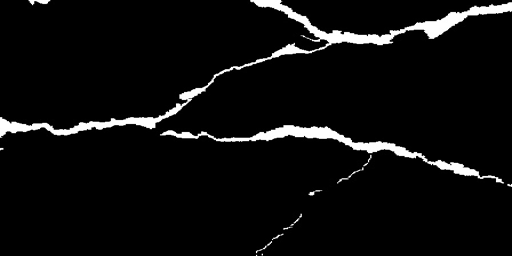

In [11]:
from torchvision import transforms

mask_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/crack（复件）/SegmentationClass/DeepCrack_11240-6.png'
validation_image = Image.open(mask_dir).convert("RGB")
validation_image.size

conditioning_image_transforms = transforms.Compose(
        [
            transforms.Resize([height, width], interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop([height, width]),
            transforms.ToTensor(),
        ]
    )


conditioning_image_pil = validation_image.resize([width, height])
conditioning_pixel_values = torch.stack([conditioning_image_transforms(conditioning_image_pil)])
conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()
print(conditioning_pixel_values.shape)
controlnet_image = conditioning_pixel_values.to(torch_device)
print(controlnet_image.shape)
print(conditioning_image_pil.mode)
conditioning_image_pil_l = conditioning_image_pil.convert('L')
print(conditioning_image_pil.mode)
print(conditioning_image_pil_l.mode)
conditioning_image_pil

In [12]:
import numpy as np
from typing import List, Optional, Tuple, Union
import PIL

def pil_to_numpy(images: Union[List[PIL.Image.Image], PIL.Image.Image]) -> np.ndarray:
    """
    Convert a PIL image or a list of PIL images to NumPy arrays.
    """
    if not isinstance(images, list):
        images = [images]
    images = [np.array(image).astype(np.float32) / 255.0 for image in images]
    images = np.stack(images, axis=0)

    return images

def numpy_to_pt(images: np.ndarray) -> torch.Tensor:
    """
    Convert a NumPy image to a PyTorch tensor.
    """
    if images.ndim == 3:
        images = images[..., None]

    images = torch.from_numpy(images.transpose(0, 3, 1, 2))
    return images

def pt_to_numpy(images: torch.Tensor) -> np.ndarray:
    """
    Convert a PyTorch tensor to a NumPy image.
    """
    images = images.cpu().permute(0, 2, 3, 1).float().numpy()
    return images

def img_normalize(images: torch.Tensor) -> torch.Tensor: # [-1, 1]
    return 2*images - 1

torch.Size([3, 512, 512]) tensor(0.0275) tensor(0.7608)
torch.Size([3, 512, 512]) tensor(-0.9451) tensor(0.5216)


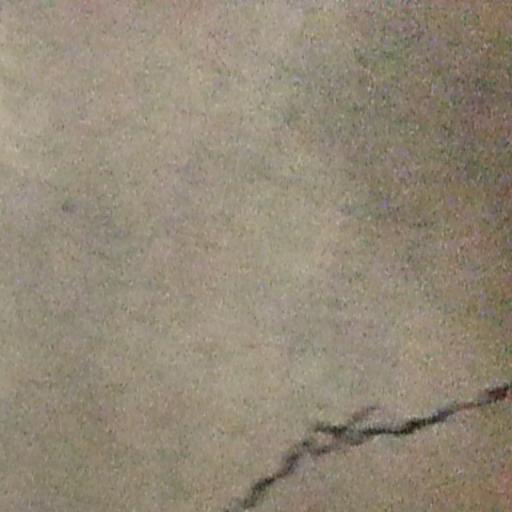

In [13]:
image_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_and_crack_dataset/target/11247-12.jpg'
org_image = Image.open(image_dir)
org_image_pt = transforms.ToTensor()(org_image)
print(org_image_pt.shape, org_image_pt.min(), org_image_pt.max())

org_image_norm_pt = img_normalize(org_image_pt)
print(org_image_norm_pt.shape, org_image_norm_pt.min(), org_image_norm_pt.max())
org_image

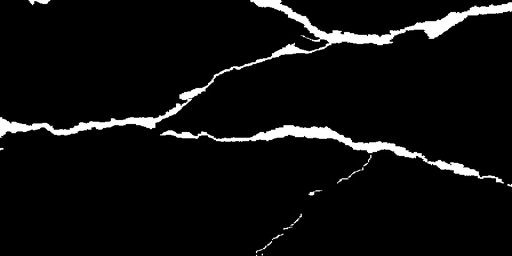

In [14]:
conditioning_image_pil_l

In [15]:
# # 如文献:https://onlinelibrary.wiley.com/doi/epdf/10.1111/mice.13171 的相加
# x0 = org_image_norm_pt # [3, 512, 512]
# mask_crack = transforms.ToTensor()(conditioning_image_pil_l)
# mask_crack_norm = img_normalize(mask_crack)
# # add_x0_
# # mask_crack.min(), mask_crack.max()
# # add_x0_mask = x0 + mask_crack
# print(x0.min(), x0.max(), x0.mean(), x0.std())
# print(mask_crack.min(), mask_crack.max(), mask_crack.mean(), mask_crack.std())
# print(mask_crack_norm.min(), mask_crack_norm.max(), mask_crack_norm.mean(), mask_crack_norm.std())

# add_x0_mask = x0 + mask_crack
# # add_x0_mask = x0 + mask_crack_norm
# add_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(add_x0_mask)
# print(add_x0_mask.shape, add_norm.min(), add_norm.max(), add_norm.mean(), add_norm.std())
# transforms.ToPILImage()(add_x0_mask)


## 3.Create random noise

In [16]:
''' 
Next, generate some initial random noise as a starting point for the diffusion process. 
This is the latent representation of the image, and it’ll be gradually denoised. 
At this point, the latent image is smaller than the final image size but that’s okay though 
because the model will transform it into the final 512x512 image dimensions later.
'''

# The height and width are divided by 8 because the vae model has 3 down-sampling layers.
# You can check by running the following:   2 ** (len(vae.config.block_out_channels) - 1) == 8

# do_classifier_free_guidance = False
# guess_mode = False

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)



latents.shape

torch.Size([1, 4, 32, 64])

In [17]:
# down_block_res_samples, mid_block_res_sample = controlnet(
#                     latents,
#                     2,
#                     encoder_hidden_states=encoder_hidden_states_control,
#                     controlnet_cond=controlnet_image,
#                     return_dict=False,
#                 )
# len(down_block_res_samples), down_block_res_samples[-1].shape, len(mid_block_res_sample), mid_block_res_sample[0].shape

## 4.Denoise the image

In [18]:
'''
Start by scaling the input with the initial noise distribution, sigma, the noise scale value, 
which is required for improved schedulers like UniPCMultistepScheduler: 
'''
print(scheduler_multistep.init_noise_sigma)
latents = latents * scheduler_multistep.init_noise_sigma
latents.shape

1.0


torch.Size([1, 4, 32, 64])

In [19]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [20]:
def show_latents(latents, vae):
    # scale and decode the image latents with vae
    latents_scaled = 1 / vae.config.scaling_factor * latents
    # pil_latents_scaled = transforms.ToPILImage()(latents.squeeze(0))
    # pil_latents_scaled = transforms.ToPILImage()(latents_scaled.squeeze(0))
    with torch.no_grad():
        # image = vae.decode(latents).sample
        image = vae.decode(latents_scaled).sample
    image = (image / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image


In [21]:
encoder_hidden_states_control.shape, text_embeddings.shape

(torch.Size([1, 77, 768]), torch.Size([2, 77, 768]))

In [22]:
'''  ***controlnet***
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

def denoise_control_sd_v15(latents, num_inference_steps=25, scheduler = scheduler_multistep, controlnet = controlnet,
                           unet = unet, text_embeddings=text_embeddings, guidance_scale=5,
                           controlnet_image=controlnet_image, encoder_hidden_states=encoder_hidden_states_control,
                           weight_dtype = torch.float32):
    scheduler.set_timesteps(num_inference_steps)

  

    for i, t in enumerate(tqdm(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        # if 
        latent_model_input = torch.cat([latents] * 2)
        # latent_model_input = latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

        # controlnet
        down_block_res_samples, mid_block_res_sample = controlnet(
                        latents,
                        t,
                        encoder_hidden_states=encoder_hidden_states,  # encoder_hidden_states_control [1,77,768]
                        controlnet_cond=controlnet_image,
                        return_dict=False,
                    )
        
        
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings, # text_embedding [2,77,768]
                                down_block_additional_residuals=[sample.to(dtype=weight_dtype) for sample in down_block_res_samples],
                                mid_block_additional_residual=mid_block_res_sample.to(dtype=weight_dtype),
                                return_dict=False,
                                )[0]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)



        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        if (i + 1) % 5 == 0:
            display_sample(latents, i + 1)
            decoded_image_pil = show_latents(latents=latents, vae=vae)
            display(decoded_image_pil)
        
    return latents

In [23]:
text_embeddings.shape

torch.Size([2, 77, 768])

torch.Size([1, 4, 32, 64])


 12%|█▏        | 3/25 [00:00<00:02, 10.98it/s]

'Image at step 5'

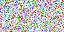

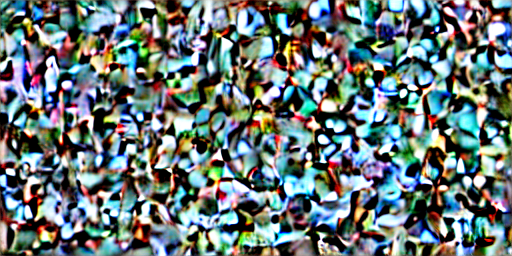

 32%|███▏      | 8/25 [00:00<00:01, 16.50it/s]

'Image at step 10'

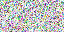

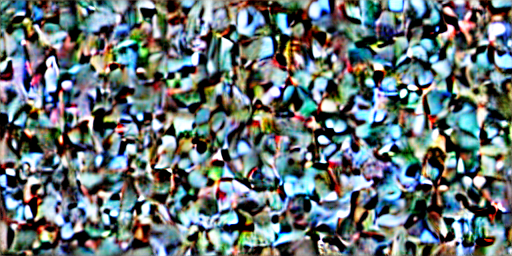

 52%|█████▏    | 13/25 [00:00<00:00, 18.25it/s]

'Image at step 15'

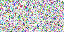

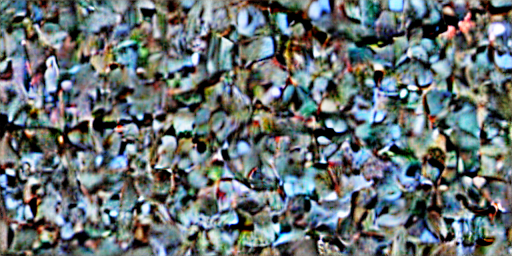

 72%|███████▏  | 18/25 [00:01<00:00, 19.01it/s]

'Image at step 20'

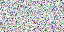

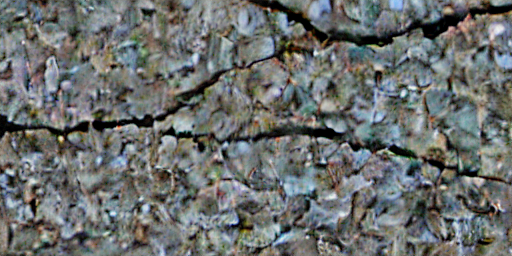

 92%|█████████▏| 23/25 [00:01<00:00, 19.02it/s]

'Image at step 25'

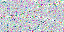

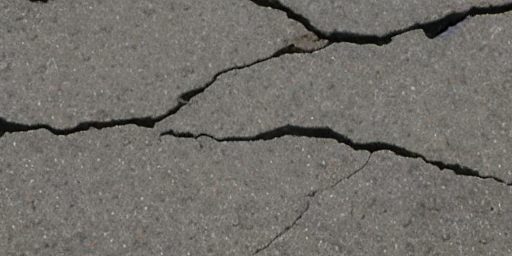

100%|██████████| 25/25 [00:01<00:00, 16.65it/s]


In [24]:
seed = 0
device = 'cuda'
generator = torch.Generator(device=device).manual_seed(seed) 
guidance_scale = 10


noise_randn =  torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

noise_randn = noise_randn * scheduler_multistep.init_noise_sigma
print(noise_randn.shape)

latents_controled = denoise_control_sd_v15(scheduler=scheduler_multistep, 
                                           latents=noise_randn,controlnet=controlnet, 
                                           controlnet_image=controlnet_image, 
                                           guidance_scale=guidance_scale,encoder_hidden_states=encoder_hidden_states_control,
                                           text_embeddings=text_embeddings)


# show_latents(latents=latents_controled, vae=vae)

In [ ]:
seed = 0
device = 'cuda'
generator = torch.Generator(device=device).manual_seed(seed) 
guidance_scale = 10


noise_randn =  torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

noise_randn = noise_randn * scheduler_multistep.init_noise_sigma
print(noise_randn.shape)

latents_controled = denoise_control_sd_v15(scheduler=scheduler_multistep, 
                                           latents=noise_randn,controlnet=controlnet, 
                                           controlnet_image=controlnet_image, 
                                           guidance_scale=guidance_scale,encoder_hidden_states=encoder_hidden_states_control,
                                           text_embeddings=text_embeddings)


# show_latents(latents=latents_controled, vae=vae)

In [ ]:
seed = 2
device = 'cuda'
generator = torch.Generator(device=device).manual_seed(seed) 
guidance_scale = 10

control_x0_add_mask = add_x0_mask.unsqueeze(0).to(device)


noise_randn =  torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

noise_randn = noise_randn * scheduler_multistep.init_noise_sigma
print(noise_randn.shape)

latents_controled = denoise_control_sd_v15(scheduler=scheduler_multistep, 
                                           latents=noise_randn,controlnet=controlnet, 
                                           controlnet_image=control_x0_add_mask, 
                                           guidance_scale=guidance_scale,encoder_hidden_states=encoder_hidden_states_control,
                                           text_embeddings=text_embeddings)

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_multistep.set_timesteps(num_inference_steps)

for t in tqdm(scheduler_multistep.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler_multistep.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler_multistep.step(noise_pred, t, latents).prev_sample

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_ddpm.set_timesteps(num_inference_steps)

for t in tqdm(scheduler_ddpm.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    # latent_model_input = latents

    latent_model_input = scheduler_ddpm.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler_ddpm.step(noise_pred, t, latents).prev_sample

In [ ]:
from PIL import Image
from torchvision import transforms

pil_latents = transforms.ToPILImage()(latents.squeeze(0))
pil_latents


## 5.Decode the image

In [ ]:
# scale and decode the image latents with vae
latents_scaled = 1 / vae.config.scaling_factor * latents
# pil_latents_scaled = transforms.ToPILImage()(latents.squeeze(0))
# pil_latents_scaled = transforms.ToPILImage()(latents_scaled.squeeze(0))
with torch.no_grad():
    # image = vae.decode(latents).sample
    image = vae.decode(latents_scaled).sample
print(image.shape)



In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image